# Importing Libraries

In [1]:
import rasterio
import matplotlib.pyplot as plt

In [2]:
from rasterio.plot import show


In [3]:
from lightning.pytorch import Trainer
from torch.utils.data import DataLoader

from torchgeo.datamodules import InriaAerialImageLabelingDataModule
from torchgeo.datasets import CDL, Landsat7, Landsat8, VHR10, stack_samples, Sentinel
from torchgeo.samplers import RandomGeoSampler
from torchgeo.trainers import SemanticSegmentationTask

c:\Users\DELL\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
import xarray as xr

### Importing LandSAT8 data - Downloaded from the USGS website

In [12]:
# landsat7 = Landsat7(root="", bands=["B1", ..., "B7"])
iowa = Landsat8(root="..\\Data\\Remote Sensing\\LandSat\\Iowa", bands=["B1", "B2", "B3", "B4", "B5", "B6", "B7"])
kansas = Landsat8(root="..\\Data\\Remote Sensing\\LandSat\\Test", bands=["B1", "B2", "B3", "B4", "B5", "B6", "B7"])

In [13]:
satellite_data = iowa | kansas

Converting Landsat8 CRS from EPSG:32614 to EPSG:32615


### Importing CDL data - 2022

In [49]:
# Importing CDL data
cdl = CDL(root="..\\Data\\Remote Sensing\\CDL22")

### Creating a datasampler for the downloaded data

In [27]:
sampler = RandomGeoSampler(satellite_data, size=256, length=5)

In [30]:
sample = next(iter(sampler))
sample

BoundingBox(minx=539594.4184219837, maxx=547274.4184219837, miny=3475100.369027853, maxy=3482780.369027853, mint=1671908400.0, maxt=1671994799.999999)

#### Loading 256x256 patches from the datasampler

Sample is a dictionary with the following keys:
- 'image': A tensor of shape (256, 256, 7) containing the image
- 'BoundingBox'
- 'crs'

In [31]:
img_sample = satellite_data[sample]
img_sample

{'crs': CRS.from_epsg(32615),
 'bbox': BoundingBox(minx=539594.4184219837, maxx=547274.4184219837, miny=3475100.369027853, maxy=3482780.369027853, mint=1671908400.0, maxt=1671994799.999999),
 'image': tensor([[[ 7646.,  7766.,  7742.,  ...,  7621.,  7755.,  7720.],
          [ 7657.,  7767.,  7756.,  ...,  7692.,  7729.,  7693.],
          [ 7683.,  7734.,  7712.,  ...,  7722.,  7789.,  7708.],
          ...,
          [ 8538.,  8602.,  8577.,  ...,  8598.,  8907.,  8735.],
          [ 8377.,  8346.,  8422.,  ...,  8414.,  8553.,  8525.],
          [ 8388.,  8267.,  8241.,  ...,  8271.,  8254.,  8101.]],
 
         [[ 7738.,  7839.,  7793.,  ...,  7710.,  7814.,  7773.],
          [ 7731.,  7839.,  7801.,  ...,  7779.,  7795.,  7750.],
          [ 7733.,  7780.,  7777.,  ...,  7783.,  7851.,  7780.],
          ...,
          [ 8787.,  8894.,  8881.,  ...,  8825.,  9228.,  8878.],
          [ 8573.,  8503.,  8521.,  ...,  8748.,  8856.,  8700.],
          [ 8566.,  8479.,  8418.,  ..., 

In [32]:
img_sample.keys()

dict_keys(['crs', 'bbox', 'image'])

### Shape of image

In [33]:
img_sample['image'].shape

torch.Size([7, 256, 256])

### Scaling images

In [34]:
def scale_image(item: dict):
    item['image'] = item['image'] * 0.0001
    return item

In [35]:
img_sample = scale_image(img_sample)

### Taking out RGB bands 3 - R, 2 - G, 1 - B

In [36]:
rgb = img_sample['image'][[3, 2, 1], :, :, ]

In [37]:
# convert rgb tensor to numpy array
rgb = rgb.numpy()

In [38]:
rgb = rgb.transpose(1, 2, 0)
rgb.shape


(256, 256, 3)

In [39]:
# clamp values to range [0, 1]
import numpy as np
rgb = np.clip(rgb, 0, 255)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


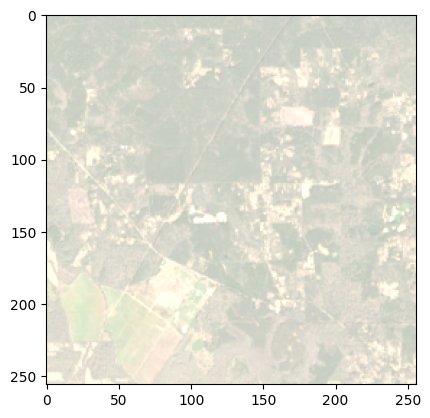

In [40]:
plt.imshow(rgb)

### TODO LIST:
- [x] Download Landsat8 data
- [x] Create a datasampler for the downloaded data
- [x] Load 256x256 patches from the datasampler
- [x] Scale images
- [x] Take out RGB bands 3 - R, 2 - G, 1 - B to plot
- [] Download Crop Data Layer (CDL) data
- [] Download more Landsat8 data
- [] Merge CDL data with Landsat8 data using TorchGeo's & operator
- [] Create a dataloader
- [] Create a model

c:\Users\DELL\AppData\Local\Programs\Python\Python310\lib\site-packages\rasterio\__init__.py:320: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


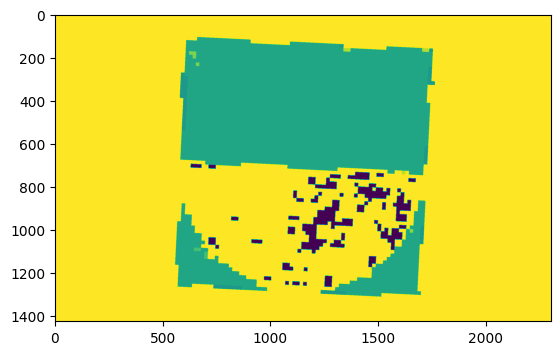

In [300]:
import rasterio
from matplotlib import pyplot
src = rasterio.open("..\Data\Remote Sensing\itqan.tif")
pyplot.imshow(src.read(1))
pyplot.show()

In [42]:
train_data = cdl & satellite_data

Converting UnionDataset CRS from EPSG:32615 to EPSG:5070


In [44]:
new_sampler = RandomGeoSampler(train_data, size=256, length=5)

In [45]:
sample = next(iter(new_sampler))

In [48]:
train_data[sample].keys()

dict_keys(['crs', 'bbox', 'mask'])